In [75]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pylab as plt
from urllib.request import urlopen
from random import shuffle
from copy import deepcopy

%matplotlib inline

In [48]:
red_delf = nx.read_gml(urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/dolphins.gml"))
gen_delf = urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/dolphinsGender.txt").readlines()

for i in range(len(gen_delf)):
    gen_delf[i]=gen_delf[i].decode()
    
sex_delf = []   
for i in range(len(gen_delf)):
    a = gen_delf[i].rstrip('\n').split('\t')
    sex_delf.append(a)

In [49]:
atributoNodos(red_delf, sex_delf, 'gender')

In [3]:
# -----------------------------------------------------------------------------

def atributoNodos(r, alist, atributo):
# Toma como argumentos una red, una lista de listas, donde cada una de ellas
# indica el atributo que se le va a asignar a cada nodo de la red. Devuelve la
# red con ese atributo ya asociado.
    for idx, nodo in enumerate(np.array(alist).transpose()[0]):
        r.nodes[nodo][atributo] = np.array(alist).transpose()[1][idx]
    
# ----------------------------------------------------------------------------- 
        
def contadorGenero(r): #Generalizarlo para cualquier atributo
    a = list(nx.get_node_attributes(r, 'gender').values())
    return a.count('m'), a.count('f'), a.count('NA')

# -----------------------------------------------------------------------------
    
def generoAzar(r):
# Toma una red donde sus nodos tienen el atributo "genero" y los distribuye al
# azar. 
# Estaría bueno generalizarlo después para cualquier atributo.
    ng = contadorGenero(r)
    n = list(r.nodes)
    shuffle(n)
    ra = deepcopy(r)
    for i in range(ng[0]):
        ra.nodes[n[i]]['gender'] = 'm'
    for i in range(ng[0], ng[0]+ng[1]):
         ra.nodes[n[i]]['gender'] = 'f'
    for i in range(ng[0]+ng[1], ng[0]+ng[1]+ng[2]):
         ra.nodes[n[i]]['gender'] = "NA"
    return ra

In [102]:
# -----------------------------------------------------------------------------

def hEdges(r, atributo):
# Recibe como argumentos una red y un cierto atributo (str) para el cual se 
# quiere ver cuántos enlaces hay entre nodos con el mismo atributo y
# cuántos entre nodos con atributos diferentes.
# Devuelve una tupla de dos números, en el primer lugar la cantidad de enlaces
# entre nodos del mismo atributo y en el segundo entre nodos de atributos 
# diferentes.
    homo = 0
    hetero = 0
    n = len(r.edges)
    for edge in r.edges:
        if r.nodes[edge[0]][atributo] == r.nodes[edge[1]][atributo]:
            homo += 1
        else:
            hetero += 1
    return homo/n, hetero/n
            
# -----------------------------------------------------------------------------            
            
def nulaAtributo(r, pasos): # Generalizarlo para cualquier atributo.
# Recibe como argumento una red y una cantidad de pasos sobre los cuales se va
# a iterar.
# Devuelve dos arrays, una con el número de enlaces homofílicos y otra con el 
# número de enlaces heterofílicos, para cada red creada al azar.
    a = []
    for i in range(pasos):
        ra = generoAzar(r)
        a.append(hEdges(ra, 'gender'))
    lhomo = np.array(a).transpose()[0]
    lhetero = np.array(a).transpose()[1]
    return lhomo, lhetero
        

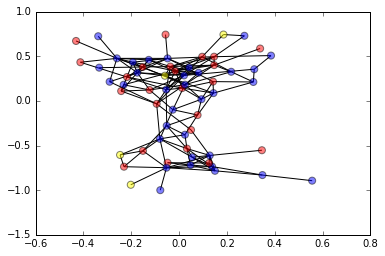

In [50]:
# -----------------------------------------------------------------------------    

        
atributoNodos(red_delf, sex_delf, 'gender')    
    
graph_pos=nx.spring_layout(red_delf)

#plt.figure(figsize=(20,20))

nx.draw_networkx_nodes(red_delf, graph_pos, node_size=50,
                       node_color = ["blue" if g=="m" else "red" if g=="f" else \
                                     "yellow" for g in nx.get_node_attributes(red_delf, 'gender').values()],
                       alpha=0.5)
nx.draw_networkx_edges(red_delf, graph_pos)
#nx.draw_networkx_labels(red_delf,graph_pos, font_size=8, font_family='sans-serif')

plt.savefig("plot.png", dpi=1000)
plt.show()



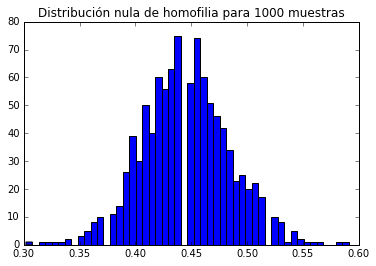

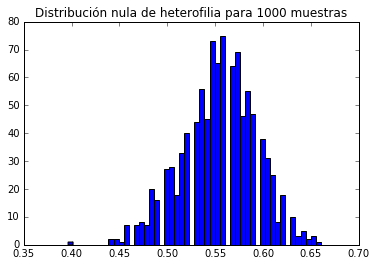

In [110]:
# -----------------------------------------------------------------------------

size = 1000
x1 = nulaAtributo(red_delf, size)[0]
x2 = nulaAtributo(red_delf, size)[1]
#bins=int(np.sqrt(size)

plt.hist(x1, bins=50)
# Hay que ver cuál es la mejor manera de poner la cantidad de bins para que se
# vea lindo. Ya probé varias maneras de ajustarlo, hasta con algunas estimaciones
# como la de Freedman-Diaconis, pero el histograma aparece entrecortado para
# un size = 10000. El 53 fue la que mejor quedó, pero lo puse a ojo.
plt.title("Distribución nula de homofilia para {} muestras".format(size))
plt.show()

plt.hist(x2, bins=50)
plt.title("Distribución nula de heterofilia para {} muestras".format(size))
plt.show()

In [111]:
(x,y) = hEdges(red_delf,'gender')

In [83]:
z = (x - np.mean(x1))/np.std(x1)

Para estimar $h =$ $\textit{"fraccion de enlaces homofilicos"}$ vamos a utilizar $\hat{h} = \bar{h}_i$, y suponiendo que no hay relación entre la topologia de la red y la asignacion de sexos, estimaremos el error con $\sigma$ (suponiendo normalidad). COMPLETAR VALORES

In [ ]:
# COMPLETAR LA CONSIGNA DE ARRIBA

In [96]:
1/np.sqrt(np.pi)

0.56418958354775628

Y el p-valor es:

In [113]:
x, y

(0.6037735849056604, 0.39622641509433965)